Note: I changed the data class internally to use a path on my computer because ray tune created one dataset for every grid point searched :)

# Import and helper functions

In [2]:
# Imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import ray
from ray import tune
from ray.air import session
from ray.tune.schedulers import ASHAScheduler

from IPython.display import clear_output

In [3]:
# Now offers a shitty way to encode months
#
# Loads and prepares the data.
# Data can be accessed over class variables: train_input_FOCI, train_target_FOCI, validation_input_FOCI...
# Unprocessed data is saved. When seq_length or feature_list are None, they are not used.
# Data is processed to have 0 mean and 1 std.
# possible_features variable contains list with all feature names, even those that have not been selected.
# For lead_time = 0, the sequences currently DO NOT contain previous prec_sahel values.
# flatten_seq = False means that each sample consits of the arrays for each time step (e.g. [t1, t2, ...])
# flatten_seq = True means that each sample contains all the values of the time steps. (array containing values vs array containing arrays of values)
# month_encoding one of ['normal', 'one_hot', 'one_hot_scaled']
class Data:
  # Split = [train,validation, test], lead_time >= 0, seq_length > 0 or None, feature_list None or list of feature names
  def __init__(self, split = [0.8, 0.1, 0.1], lead_time = 0, seq_length=None, flatten_seq=False, feature_list=None, month_encoding='normal'):
    # Variables
    self.scale_one_hot = False
    self.possible_features = [] # Filled later on to track all possible features before selection
    self.current_features = [] # Filled later to track selected features
    self.one_hot_column_names = [] # Filled later if one_hot_encode_months is set to true
    self.__data_url = (
    "https://github.com/MarcoLandtHayen/climate_index_collection/"
    "releases/download/v2023.03.29.1/climate_indices.csv"
    )
    
    # Set variables for month encoding setting
    if month_encoding == 'normal':
        one_hot_encode_months = False
    elif month_encoding == 'one_hot':
        one_hot_encode_months = True
    elif month_encoding == 'one_hot_scaled':
        one_hot_encode_months = True
        self.scale_one_hot = True
    else:
        raise ValueError("month_encoding has to be one of: {} but was {}".format(['normal', 'one_hot', 'one_hot_scaled'], month_encoding))

    # Load the data
    FOCI, CESM = self.__load_data()
    
    # Get one_hot encodings for months and then remove the month column then join them back together
    # The one hot encoded columns will be normalised later.
    if one_hot_encode_months:
      one_hot_FOCI = pd.get_dummies(FOCI['month'], prefix='month')
      one_hot_CESM = pd.get_dummies(CESM['month'], prefix='month')
      self.one_hot_column_names = list(one_hot_FOCI.columns)  # Save one hot encoded column names to exclude from standarisation
      FOCI = one_hot_FOCI.join(FOCI.drop('month',axis = 1))
      CESM = one_hot_CESM.join(CESM.drop('month',axis = 1))


    # Split into input and target
    input_FOCI, target_FOCI = self.__get_input_target(FOCI, lead_time)
    input_CESM, target_CESM = self.__get_input_target(CESM, lead_time)

    # Save possible features that can be selected
    self.possible_features = list(input_FOCI.columns)

    # Select features if any are set
    input_FOCI = input_FOCI if feature_list is None else input_FOCI[feature_list]
    input_CESM = input_CESM if feature_list is None else input_CESM[feature_list]

    # Save selected features
    self.current_features = list(input_FOCI.columns)

    # Split into train, validation and test, based on split percentage given
    self.train_input_FOCI, self.validation_input_FOCI, self.test_input_FOCI = self.__get_train_validation_test(input_FOCI, split)
    self.train_target_FOCI, self.validation_target_FOCI, self.test_target_FOCI = self.__get_train_validation_test(target_FOCI, split)

    self.train_input_CESM, self.validation_input_CESM, self.test_input_CESM = self.__get_train_validation_test(input_CESM, split)
    self.train_target_CESM, self.validation_target_CESM, self.test_target_CESM = self.__get_train_validation_test(target_CESM, split)

    # Fit standardscaler on trainings data and then scale train, validation and test input with it to obtain 0 mean and 1 std
    # Returned values are numpy arrays
    self.train_input_FOCI, self.validation_input_FOCI, self.test_input_FOCI = self.__scale_data(self.train_input_FOCI, self.validation_input_FOCI, self.test_input_FOCI)
    self.train_input_CESM, self.validation_input_CESM, self.test_input_CESM = self.__scale_data(self.train_input_CESM, self.validation_input_CESM, self.test_input_CESM)

    # Do the same with the target data
    self.train_target_FOCI, self.validation_target_FOCI, self.test_target_FOCI = self.__scale_data(self.train_target_FOCI, self.validation_target_FOCI, self.test_target_FOCI)
    self.train_target_CESM, self.validation_target_CESM, self.test_target_CESM = self.__scale_data(self.train_target_CESM, self.validation_target_CESM, self.test_target_CESM)

    # Turn target arrays into 1D arrays, reshape only if array actually exists
    # otherwise an error would be thrown.
    if len(self.train_target_FOCI) > 0:
      self.train_target_FOCI = self.train_target_FOCI.reshape(-1)
      self.train_target_CESM = self.train_target_CESM.reshape(-1)
    if len(self.validation_target_FOCI) > 0:
      self.validation_target_FOCI = self.validation_target_FOCI.reshape(-1)
      self.validation_target_CESM = self.validation_target_CESM.reshape(-1)
    if len(self.test_target_FOCI) > 0:
      self.test_target_FOCI = self.test_target_FOCI.reshape(-1)
      self.test_target_CESM = self.test_target_CESM.reshape(-1)

    # Turn data into sequences consisting of seq_length timesteps
    if seq_length is not None:
      # Check for valid seq_length
      if seq_length <= 0:
        raise ValueError('seq_length has to be an integer > 0 or None but is{}'.format(seq_length))

      # Train FOCI
      if len(self.train_input_FOCI) > 0:
        self.train_input_FOCI, self.train_target_FOCI = self.__into_sequence(self.train_input_FOCI, self.train_target_FOCI, seq_length, flatten_seq)
      # Validation FOCI
      if len(self.validation_input_FOCI) > 0:
        self.validation_input_FOCI, self.validation_target_FOCI = self.__into_sequence(self.validation_input_FOCI, self.validation_target_FOCI, seq_length, flatten_seq)
      # Test FOCI
      if len(self.test_input_FOCI) > 0:
        self.test_input_FOCI, self.test_target_FOCI = self.__into_sequence(self.test_input_FOCI, self.test_target_FOCI, seq_length, flatten_seq)
      # Train CESM
      if len(self.train_input_CESM) > 0:
        self.train_input_CESM, self.train_target_CESM = self.__into_sequence(self.train_input_CESM, self.train_target_CESM, seq_length, flatten_seq)
      # Validation CESM
      if len(self.validation_input_CESM) > 0:
        self.validation_input_CESM, self.validation_target_CESM = self.__into_sequence(self.validation_input_CESM, self.validation_target_CESM, seq_length, flatten_seq)
      # Test CESM
      if len(self.test_input_CESM) > 0:
        self.test_input_CESM, self.test_target_CESM = self.__into_sequence(self.test_input_CESM, self.test_target_CESM, seq_length, flatten_seq)


  # Loads the data from url or disk, returns FOCI, CESM as pandas dataframes.
  def __load_data(self):

    # Check if data exists on disk, if so load from disk, otherwise from url
    if os.path.exists('C:\\Users\\Jannik\\climate_indices.csv'):
      climind = pd.read_csv('C:\\Users\\Jannik\\climate_indices.csv')
    else:
      climind = pd.read_csv(self.__data_url)
      # Save data to disk
      climind.to_csv('C:\\Users\\Jannik\\climate_indices.csv', index=False)

    # Split into FOCI and CESM and drop year
    climind = climind.set_index(["model", "year", "month", "index"]).unstack(level=-1)["value"]
    FOCI = climind.loc[('FOCI')].reset_index().drop(columns=['year'])
    CESM = climind.loc[('CESM')].reset_index().drop(columns=['year'])

    # Return them
    return FOCI, CESM

  # Takes the FOCI or CESM pandas dataframe and returns the input and target
  # Input and target depends on the lead_time, for lead_time >0 input contains
  # PREC_SAHEL of the current time step, for lead_time = 0 it does not.
  # lead_time determines how many months in advance the target is.
  def __get_input_target(self, data, lead_time):
    # Check if lead_time is vlaid
    if lead_time < 0:
      raise ValueError('lead_time has to have a value >= 0 but has value {}'.format(self.__lead_time))

    # Split into target and input, input has to omit the last lead_time elements or there would be no target for them
    target = data.loc[:,data.columns == 'PREC_SAHEL']
    input = data.loc[:,data.columns != 'PREC_SAHEL'] if lead_time == 0 else data[:-lead_time]

    # Adjust target for lead_time if needed
    if lead_time > 0:
      target = target[lead_time:]

    # Return input and target
    return input, target

  # Splits data based on the given split into train, validation and test
  # split = [train, validation, test] as decimal indicating percentage
  def __get_train_validation_test(self, data, split):
    # Check if split is valid
    if sum(split) != 1 or split[0] <= 0 or any(i < 0 for i in split):
      raise ValueError('Invalid split has been passed. Values can be negative, have to sum up to 1 and train has to be > 0')

    # Get number of samples for each split
    n_train = int(split[0] * len(data))
    n_val = int(split[1] * len(data))
    n_test = int(split[2] * len(data))  # Only used to check if there is a test set

    # Create the splits
    train = data[:n_train] if n_train > 0 else []
    val =  data[n_train:n_train+n_val] if n_val > 0 else []
    test = data[n_train+n_val:] if n_test > 0 else []

    # Return them
    return train, val, test

  # Scales the data so that the resulting data has mean of 0 and std of 1
  def __scale_data(self, train, val, test):
    scaler = None

    # If scale_one_hot is set to false exclude the one hot encoded columns before using the Standardscaler
    if self.scale_one_hot:
      scaler = StandardScaler()
    # Otherwise also scale them
    else:
      features = [feature_name for feature_name in train.columns if feature_name not in self.one_hot_column_names]
      scaler = ColumnTransformer([('normal features', StandardScaler(), features)], remainder='passthrough')

    # Fit on train data
    scaler.fit(train)

    # Transform train, val, test sets if they are non empty
    scaled_train = scaler.transform(train) if len(train) > 0 else []
    scaled_val = scaler.transform(val) if len(val) > 0 else []
    scaled_test = scaler.transform(test) if len(test) > 0 else []

    return scaled_train, scaled_val, scaled_test

  # Turns input into a sequence consisting of seq_length time steps
  # and selects i+seq_length-1 as the corresponding target index for the i'th sequence.
  def __into_sequence(self, input, target, seq_length, flatten_seq):
    input_seq = np.array([input[i:i+seq_length] for i in range(len(input)-seq_length)])
    target_seq = np.array([target[i+seq_length-1] for i in range(len(target)-seq_length)])

    # Flatten sample containing the sequences if wanted (sample = [t_0, t_1,...] with t_0 = [feature_1, feature_2,...])
    if flatten_seq:
      input_seq = [seq.reshape(-1) for seq in input_seq]

    return input_seq, target_seq

In [4]:
# Class used to store the data for pytorch
class RegressionDataset(Dataset):
    def __init__(self, input, target):
        self.input = torch.tensor(input, dtype=torch.float32)
        self.target = torch.tensor(target.reshape(-1,1), dtype=torch.float32)

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        x = self.input[idx]
        y = self.target[idx]
        return x, y

# LSTM

In [5]:
# Training loops
def train_model(config, early_stopping_steps=5):
  # Set torch random seed
  torch.manual_seed(0)
    
  # Select device
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
  # Data stuff
  data = Data(lead_time=config['lead_time'], seq_length=config['seq_length'], feature_list=config['feature_selection'], month_encoding=config['month_encoding'])

  train_data_FOCI = RegressionDataset(data.train_input_FOCI, data.train_target_FOCI)
  val_data_FOCI = RegressionDataset(data.validation_input_FOCI, data.validation_target_FOCI)

  train_dataloader = DataLoader(train_data_FOCI, batch_size=32, shuffle=True)
  val_dataloader = DataLoader(val_data_FOCI, batch_size=32, shuffle=False)

  # Create model
  input_len = len(data.train_input_FOCI[0][0])
  model = LSTM(num_in=input_len, config=config)

  # Move model to device
  model.to(device)
    
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

  # Train the model
  steps_since_improvement = 0
  best_val_loss = float('inf')
  while steps_since_improvement < early_stopping_steps:
    model.train()
    # Train the model on all batches
    for i, (inputs, targets) in enumerate(train_dataloader):
      inputs = inputs.to(device)
      targets = targets.to(device)
    
      optimizer.zero_grad()
      out = model(inputs)
      loss = criterion(out, targets)
      loss.backward()
      optimizer.step()

    # Calculate validation loss
    val_loss = 0.0
    model.eval()
    for i, (inputs, targets) in enumerate(val_dataloader):
      inputs = inputs.to(device)
      targets = targets.to(device)    
        
      out = model(inputs)
      loss = criterion(out, targets)
      val_loss += loss.item()

    # Adjust val loss for number of samples
    val_loss = val_loss / len(val_dataloader)
    
    # Check if current validation loss is improvement ofer best
    if val_loss < best_val_loss:
        # If so update best validation loss and reset steps_since_improvement
        best_val_loss = val_loss
        steps_since_improvement = 0
    else:
        # Otherwise increase the steps since improvement by 1
        steps_since_improvement += 1
    
    # Report loss
    session.report({'mean_squared_error': best_val_loss})

In [6]:
# Used to reshape x after the lstm layer
# First the hidden state is removed from x and then the final lstm output is selected
class ReshapeLayer(nn.Module):
    def forward(self, x):
        x = x[0]
        return x[:, -1, :]

In [7]:
class LSTM(nn.Module):
    def __init__(self, num_in, config):
        super(LSTM, self).__init__()
        # Prepare variables because im lazy to change it incode
        lstm_layers = config['lstm_layers']
        lstm_neurons = config['lstm_neurons']
        fc_layers = config['fc_layers']
        fc_neurons = config['fc_neurons']
        activation_function = config['activation_func']
        
        # Module list to hold the layers
        self.layers = nn.ModuleList([])

        # Add lstm layer(s) and batch normalisation
        self.layers.append(nn.LSTM(input_size=num_in, hidden_size=lstm_neurons, num_layers=lstm_layers, batch_first=True))
        self.layers.append(ReshapeLayer())
        self.layers.append(nn.BatchNorm1d(lstm_neurons))
        # Now add fully connected layers with batch normalisation and relu activation function
        for i in range(fc_layers):
          # If its first fc layer set appropriate input size
          if i == 0:
            self.layers.append(nn.Linear(lstm_neurons, fc_neurons))
            self.layers.append(nn.BatchNorm1d(fc_neurons))
            self.layers.append(activation_function())
          # If its the last layer make sure it gets 1 neuron as output and a linear activation function
          elif i == fc_layers-1:
            self.layers.append(nn.Linear(fc_neurons, 1))
          # If neither add layers normally
          else:
            self.layers.append(nn.Linear(fc_neurons, fc_neurons))
            self.layers.append(nn.BatchNorm1d(fc_neurons))
            self.layers.append(activation_function())

    # TODO: consider adding the x transformation as a function instead to be more modular
    def forward(self, x):
      for layer in self.layers:
        x = layer(x)

      return x

In [8]:
# Uses ray to perform the grid search over the search space
def search_in_space(search_space):
    trainable = tune.with_resources(train_model, {"cpu": 1, "gpu": 0.5})
    
    tuner = tune.Tuner(
    train_model,
    tune_config=tune.TuneConfig(
        num_samples=1,
        scheduler=ASHAScheduler(metric="mean_squared_error", mode="min"),
    ),
    param_space=search_space
    )
    
    results = tuner.fit()
    
    return results

In [9]:
# Takes the result from search in space and returns a config
# with the best setting
def get_best_settings(result, search_space_keys):
    # Sort the result by mse
    res = result.sort_values('mean_squared_error')
    res = res.reset_index()
    res['mean_squared_error'] = res['mean_squared_error'].apply(lambda x: format(x, 'f'))
    
    # Extract relevant columns and mse to display
    selection = ['config/{}'.format(name) for name in search_space_keys]
    res = res[selection + ['mean_squared_error']]
    clear_output()
    display(res.head(10))
    
    # The only the relevant columns for the best_setting
    res = res[selection]
    
    # Extract the best result
    best_setting = res.iloc[0].to_dict()
    
    # Change key names from config/key_name back to key_name
    # Wrapped in a list so that lists (e.g. selected features) are used as a single item in the next search
    best_setting = {key: value for (key, value) in zip(search_space_keys, best_setting.values())}
    
    # Turn activation function from string back into a class
    func = best_setting['activation_func'].split("'")[1]
    func = eval(func)
    best_setting['activation_func'] = func
    
    # Return the extracted results
    return best_setting

# NAS

In [10]:
# Fix random seed, this is also done inside the training methods ray uses otherwise it will not be fixed on the nodes
torch.manual_seed(0)

In [11]:
# learning rate didn't seem to strongly change
# weight decay and dropout seemed to never perform better
# smaller layer/neuron numbers removed because bigger performed better

# Prepare ray
ray.shutdown()
ray.init(num_cpus=9, num_gpus=1)

2023-07-07 00:51:08,211	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.9
Ray version:,2.5.1
Dashboard:,http://127.0.0.1:8265


In [12]:
# Search for a fitting architecture (using relu as activation function  for now and fixed learning rate + weight decay)
search_space = {
    'lead_time': tune.grid_search([1]),
    'seq_length': tune.grid_search([18]),
    #'activation_func': tune.grid_search([nn.ReLU, nn.LeakyReLU, nn.Tanh]),
    'activation_func': nn.ReLU,
    'weight_decay': tune.grid_search([0]),
    'learning_rate': tune.grid_search([0.001]),
    'lstm_neurons': tune.grid_search([16, 32, 64, 128]),
    'lstm_layers': tune.grid_search([1, 2, 4]),
    'fc_neurons': tune.grid_search([8, 16, 32, 64, 128]),
    'fc_layers': tune.grid_search([2, 4, 6, 8, 10]),
    'feature_selection': tune.grid_search([None]),
    'month_encoding': tune.grid_search(['normal'])
}
# Perform gridsearch and get best settings
result = search_in_space(search_space).get_dataframe()
search_space = get_best_settings(result, search_space.keys())

,config/lead_time,config/seq_length,config/activation_func,config/weight_decay,config/learning_rate,config/lstm_neurons,config/lstm_layers,config/fc_neurons,config/fc_layers,config/feature_selection,config/month_encoding,mean_squared_error
0,1,18,<class 'torch.nn.modules.activation.ReLU'>,0,0.001,64,2,8,2,None,normal,0.862139
1,1,18,<class 'torch.nn.modules.activation.ReLU'>,0,0.001,64,1,16,4,None,normal,0.872877
2,1,18,<class 'torch.nn.modules.activation.ReLU'>,0,0.001,128,1,128,4,None,normal,0.876308
3,1,18,<class 'torch.nn.modules.activation.ReLU'>,0,0.001,128,1,32,2,None,normal,0.876370
4,1,18,<class 'torch.nn.modules.activation.ReLU'>,0,0.001,128,2,16,2,None,normal,0.877060
5,1,18,<class 'torch.nn.modules.activation.ReLU'>,0,0.001,64,1,32,2,None,normal,0.877784
6,1,18,<class 'torch.nn.modules.activation.ReLU'>,0,0.001,128,1,16,2,None,normal,0.878315
7,1,18,<class 'torch.nn.modules.activation.ReLU'>,0,0.001,128,2,8,2,None,normal,0.881602
8,1,18,<class 'torch.nn.modules.activation.ReLU'>,0,0.001,32,4,8,2,None,normal,0.881851
9,1,18,<class 'torch.nn.modules.activation.ReLU'>,0,0.001,128,1,8,2,None,normal,0.886509


# Search for learning rate and weight decay

In [13]:
# Search for for learning rate and weight decay
search_space['learning_rate'] = tune.grid_search([0.005, 0.0025, 0.001, 0.0005, 0.00025, 0.0001])
search_space['weight_decay'] = tune.grid_search([0, 1e-6, 1e-5, 1e-4])

# Search for best for learning rate and weight decay
result = search_in_space(search_space).get_dataframe()
search_space = get_best_settings(result, search_space.keys())

,config/lead_time,config/seq_length,config/activation_func,config/weight_decay,config/learning_rate,config/lstm_neurons,config/lstm_layers,config/fc_neurons,config/fc_layers,config/feature_selection,config/month_encoding,mean_squared_error
0,1,18,<class 'torch.nn.modules.activation.ReLU'>,0.000010,0.0025,64,2,8,2,None,normal,0.881151
1,1,18,<class 'torch.nn.modules.activation.ReLU'>,0.000000,0.0025,64,2,8,2,None,normal,0.883607
2,1,18,<class 'torch.nn.modules.activation.ReLU'>,0.000001,0.0025,64,2,8,2,None,normal,0.885452
3,1,18,<class 'torch.nn.modules.activation.ReLU'>,0.000100,0.0025,64,2,8,2,None,normal,0.889866
4,1,18,<class 'torch.nn.modules.activation.ReLU'>,0.000010,0.0050,64,2,8,2,None,normal,0.898101
5,1,18,<class 'torch.nn.modules.activation.ReLU'>,0.000000,0.0050,64,2,8,2,None,normal,0.900295
6,1,18,<class 'torch.nn.modules.activation.ReLU'>,0.000100,0.0050,64,2,8,2,None,normal,0.906306
7,1,18,<class 'torch.nn.modules.activation.ReLU'>,0.000001,0.0050,64,2,8,2,None,normal,0.940566
8,1,18,<class 'torch.nn.modules.activation.ReLU'>,0.000000,0.0010,64,2,8,2,None,normal,0.948283
9,1,18,<class 'torch.nn.modules.activation.ReLU'>,0.000001,0.0010,64,2,8,2,None,normal,0.948727


# Determine sequence length
For each lead time the previously "best" sequence length is included in the grid search

I never determined an optimal sequence length for lead time 6 as the performance dropped strongly.

In [14]:
# Lead time 0
search_space['lead_time'] = 0
search_space['seq_length'] = tune.grid_search([9, 12, 24, 36, 48, 60])
result = search_in_space(search_space).get_dataframe()
best_setting_lt0 = get_best_settings(result, search_space.keys())

,config/lead_time,config/seq_length,config/activation_func,config/weight_decay,config/learning_rate,config/lstm_neurons,config/lstm_layers,config/fc_neurons,config/fc_layers,config/feature_selection,config/month_encoding,mean_squared_error
0,0,9,<class 'torch.nn.modules.activation.ReLU'>,0.00001,0.0025,64,2,8,2,None,normal,0.586908
1,0,24,<class 'torch.nn.modules.activation.ReLU'>,0.00001,0.0025,64,2,8,2,None,normal,0.603921
2,0,12,<class 'torch.nn.modules.activation.ReLU'>,0.00001,0.0025,64,2,8,2,None,normal,0.607799
3,0,48,<class 'torch.nn.modules.activation.ReLU'>,0.00001,0.0025,64,2,8,2,None,normal,0.672034
4,0,36,<class 'torch.nn.modules.activation.ReLU'>,0.00001,0.0025,64,2,8,2,None,normal,0.701822
5,0,60,<class 'torch.nn.modules.activation.ReLU'>,0.00001,0.0025,64,2,8,2,None,normal,0.748380


In [15]:
# Lead time 1
search_space['lead_time'] = 1
search_space['seq_length'] = tune.grid_search([12, 18, 24, 36, 48, 60, 72])
result = search_in_space(search_space).get_dataframe()
best_setting_lt1 = get_best_settings(result, search_space.keys())

,config/lead_time,config/seq_length,config/activation_func,config/weight_decay,config/learning_rate,config/lstm_neurons,config/lstm_layers,config/fc_neurons,config/fc_layers,config/feature_selection,config/month_encoding,mean_squared_error
0,1,48,<class 'torch.nn.modules.activation.ReLU'>,0.00001,0.0025,64,2,8,2,None,normal,0.875900
1,1,18,<class 'torch.nn.modules.activation.ReLU'>,0.00001,0.0025,64,2,8,2,None,normal,0.881151
2,1,72,<class 'torch.nn.modules.activation.ReLU'>,0.00001,0.0025,64,2,8,2,None,normal,0.923720
3,1,36,<class 'torch.nn.modules.activation.ReLU'>,0.00001,0.0025,64,2,8,2,None,normal,0.928180
4,1,60,<class 'torch.nn.modules.activation.ReLU'>,0.00001,0.0025,64,2,8,2,None,normal,0.930582
5,1,24,<class 'torch.nn.modules.activation.ReLU'>,0.00001,0.0025,64,2,8,2,None,normal,0.930884
6,1,12,<class 'torch.nn.modules.activation.ReLU'>,0.00001,0.0025,64,2,8,2,None,normal,0.961490


In [16]:
# Lead time 3
search_space['lead_time'] = 3
search_space['seq_length'] = tune.grid_search([12, 22, 24, 36, 48, 60, 72])
result = search_in_space(search_space).get_dataframe()
best_setting_lt3 = get_best_settings(result, search_space.keys())

,config/lead_time,config/seq_length,config/activation_func,config/weight_decay,config/learning_rate,config/lstm_neurons,config/lstm_layers,config/fc_neurons,config/fc_layers,config/feature_selection,config/month_encoding,mean_squared_error
0,3,22,<class 'torch.nn.modules.activation.ReLU'>,0.00001,0.0025,64,2,8,2,None,normal,0.975383
1,3,24,<class 'torch.nn.modules.activation.ReLU'>,0.00001,0.0025,64,2,8,2,None,normal,0.989886
2,3,48,<class 'torch.nn.modules.activation.ReLU'>,0.00001,0.0025,64,2,8,2,None,normal,0.992731
3,3,36,<class 'torch.nn.modules.activation.ReLU'>,0.00001,0.0025,64,2,8,2,None,normal,1.002827
4,3,72,<class 'torch.nn.modules.activation.ReLU'>,0.00001,0.0025,64,2,8,2,None,normal,1.010584
5,3,12,<class 'torch.nn.modules.activation.ReLU'>,0.00001,0.0025,64,2,8,2,None,normal,1.020079


In [17]:
# Lead time 6
search_space['lead_time'] = 6
search_space['seq_length'] = tune.grid_search([12, 24, 36, 48, 60, 72])
result = search_in_space(search_space).get_dataframe()
best_setting_lt6 = get_best_settings(result, search_space.keys())

,config/lead_time,config/seq_length,config/activation_func,config/weight_decay,config/learning_rate,config/lstm_neurons,config/lstm_layers,config/fc_neurons,config/fc_layers,config/feature_selection,config/month_encoding,mean_squared_error
0,6,12,<class 'torch.nn.modules.activation.ReLU'>,0.00001,0.0025,64,2,8,2,None,normal,0.974734
1,6,48,<class 'torch.nn.modules.activation.ReLU'>,0.00001,0.0025,64,2,8,2,None,normal,0.987189
2,6,24,<class 'torch.nn.modules.activation.ReLU'>,0.00001,0.0025,64,2,8,2,None,normal,1.000819
3,6,72,<class 'torch.nn.modules.activation.ReLU'>,0.00001,0.0025,64,2,8,2,None,normal,1.011344
4,6,60,<class 'torch.nn.modules.activation.ReLU'>,0.00001,0.0025,64,2,8,2,None,normal,1.013262
5,6,36,<class 'torch.nn.modules.activation.ReLU'>,0.00001,0.0025,64,2,8,2,None,normal,1.019501


# Forward select features

From here on out raytune is no longer used because its easier/quicker to implement without

In [18]:
# Plots training and validation loss + adds a vertical line at lowest validation loss to show the selected model
def visualise_loss_history(training_loss_history, validation_loss_history, title='Training and Validation loss'):
  val, idx = min((val, idx) for (idx, val) in enumerate(validation_loss_history))
  plt.plot(training_loss_history, label='train_loss')
  plt.plot(validation_loss_history,label='val_loss')
  plt.axvline(x=idx, label='min val_loss', color='gray')
  plt.legend()
  plt.title(title)
  plt.show()

In [19]:
# was brauche ich
# normale trainings loop welche mir best val_mse wieder gibt

# Trainings loop without raytune
# todo: visualize training history or return it
def train_model_normal(model, data, config, early_stopping_steps=5, visualize_training=True):
  # Set torch random seed
  torch.manual_seed(0)
    
  # Select device
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # Create Dataloaders
  train_data_FOCI = RegressionDataset(data.train_input_FOCI, data.train_target_FOCI)
  val_data_FOCI = RegressionDataset(data.validation_input_FOCI, data.validation_target_FOCI)

  train_dataloader = DataLoader(train_data_FOCI, batch_size=32, shuffle=True)
  val_dataloader = DataLoader(val_data_FOCI, batch_size=32, shuffle=False)

  # Move model to device
  model.to(device)
    
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

  # Train the model
  steps_since_improvement = 0
  best_val_loss = float('inf')
  train_loss_hist = []
  val_loss_hist = []

  while steps_since_improvement < early_stopping_steps:
    # Train the model on all batches
    train_loss = 0.0
    model.train()
    for i, (inputs, targets) in enumerate(train_dataloader):
      inputs = inputs.to(device)
      targets = targets.to(device)
    
      optimizer.zero_grad()
      out = model(inputs)
      loss = criterion(out, targets)
      train_loss += loss.item()
      loss.backward()
      optimizer.step()
    
    # Adjust train loss for number of samples
    train_loss = train_loss / len(train_dataloader)
    
    # Add train loss to history
    train_loss_hist.append(train_loss)
    
    # Calculate validation loss
    val_loss = 0.0
    model.eval()
    for i, (inputs, targets) in enumerate(val_dataloader):
      inputs = inputs.to(device)
      targets = targets.to(device)    
        
      out = model(inputs)
      loss = criterion(out, targets)
      val_loss += loss.item()

    # Adjust val loss for number of samples
    val_loss = val_loss / len(val_dataloader)
    
    # Add validation loss to history
    val_loss_hist.append(val_loss)
    
    # Check if current validation loss is improvement ofer best
    if val_loss < best_val_loss:
        # If so update best validation loss and reset steps_since_improvement
        best_val_loss = val_loss
        steps_since_improvement = 0
    else:
        # Otherwise increase the steps since improvement by 1
        steps_since_improvement += 1

  # Print train/val loss history
  if visualize_training:
    visualise_loss_history(train_loss_hist, val_loss_hist)
    
  # Return lowest validation loss
  return best_val_loss

In [20]:
def feature_select(config):
  # Create data for inital model and save all possible feature names
  data = Data(lead_time=config['lead_time'], seq_length=config['seq_length'])
  all_feature_names = data.current_features.copy()
  
  # Create min_mse
  min_mse = float('inf')
  
  # Train initial model and get initial mse
  input_len = len(data.train_input_FOCI[0][0])
  model = LSTM(num_in=input_len, config=config)
  init_mse = train_model_normal(model, data, config)

  # Perform forward selection
  selection = []
  for name in all_feature_names:
    # Add new feature
    selection.append(name)
    
    # Train model with selected features
    data = Data(lead_time=config['lead_time'], seq_length=config['seq_length'], feature_list=selection)
    input_len = len(selection)
    model = LSTM(num_in=input_len, config=config)
    mse = train_model_normal(model, data, config)
    
    # Check if selected feature improved performance
    if mse < min_mse:
        min_mse = mse
    # And if not, remove the feature from the selection
    else:
        selection = selection[:-1]
        
  # Check if feature selection is an improvement over using all features
  clear_output()
  if min_mse < init_mse:
    print('Found a selection of features that improves performance.')
    print('MSE all features: {}'.format(init_mse))
    print('MSE after selection: {}'.format(min_mse))
    print('Selected features: {}'.format(selection))
  # If no improvement has been found set selection to None to keep using all features
  else:
    print('Could not find a feature selection that improved performance')
    print('MSE all features: {}'.format(init_mse))
    print('MSE after selection: {}'.format(min_mse))
    print('All features will be used')
    selection = None

  # Return a config with the feature selection
  selected_config = config.copy()
  selected_config['feature_selection'] = selection

  return selected_config

In [21]:
selected_lt0 = feature_select(best_setting_lt0)

Found a selection of features that improves performance.
MSE all features: 0.5999651759078628
MSE after selection: 0.5723370992039379
Selected features: ['month', 'AMO', 'ENSO_12', 'ENSO_3', 'NAO_ST', 'SAM_PC', 'SAT_N_ALL', 'SAT_N_LAND', 'SAT_N_OCEAN', 'SST_HMDR', 'SST_MED', 'SST_TNA', 'SST_TSA']


In [22]:
selected_lt1 = feature_select(best_setting_lt1)

Found a selection of features that improves performance.
MSE all features: 0.8869806925455729
MSE after selection: 0.8808096125721931
Selected features: ['month', 'AMO', 'ENSO_3', 'ENSO_34', 'ENSO_4', 'PREC_SAHEL', 'SAT_N_LAND']


In [23]:
selected_lt3 = feature_select(best_setting_lt3)

Found a selection of features that improves performance.
MSE all features: 0.988202074895034
MSE after selection: 0.9556518301770494
Selected features: ['month', 'AMO', 'ENSO_12', 'ENSO_3', 'ENSO_34', 'ENSO_4']


In [24]:
selected_lt6 = feature_select(best_setting_lt6)

Found a selection of features that improves performance.
MSE all features: 0.9806476337345023
MSE after selection: 0.9408106992119237
Selected features: ['month', 'AMO', 'ENSO_12', 'ENSO_3', 'ENSO_34', 'SAM_PC', 'SAT_S_LAND', 'SSS_SA', 'SST_ESIO']


# Compare different ways to encode months (for each lead time)




In [25]:
def find_best_encoding(config):
  encoding_options = ['normal', 'one_hot', 'one_hot_scaled']
  min_mse = float('inf')
  best_encoding = None
  best_selection = None
    
  for encoding in encoding_options:
    selection = config['feature_selection']
    
    # Adjust feature selectino if needed, one hot encoded data has month_1,...,month_12 instead of month
    if encoding != 'normal' and config['feature_selection'] != None and 'month' in config['feature_selection']:
        selection = ['month_{}'.format(i) for i in range(1,13)] + config['feature_selection']
        selection.remove('month')
        
    # Train model and get mse
    data = Data(lead_time=config['lead_time'], seq_length=config['seq_length'], feature_list=selection, month_encoding=encoding)
    input_len = len(selection)
    model = LSTM(num_in=input_len, config=config)
    mse = train_model_normal(model, data, config, visualize_training=False)
    
    # Test if current encoding is an improvement
    if mse < min_mse:
        min_mse = mse
        best_encoding = encoding
        best_selection = selection
    
    # Print out information about current encoding
    print('Encoding {} has MSE of: {}'.format(encoding, mse))
    
  # Print results
  print('\nBest encoding is {} with {} MSE'.format(best_encoding, min_mse))      
        
  # Return the best found encoding (and selection)
  best_config = config.copy()
  best_config['encoding'] = best_encoding
  best_config['feature_selection'] = best_selection
  
  return best_config  

In [26]:
encoded_lt0 = find_best_encoding(selected_lt0)

Encoding normal has MSE of: 0.5661071448733932
Encoding one_hot has MSE of: 0.5685825112618899
Encoding one_hot_scaled has MSE of: 0.5599108699120974

Best encoding is one_hot_scaled with 0.5599108699120974 MSE


In [27]:
encoded_lt1 = find_best_encoding(selected_lt1)

Encoding normal has MSE of: 0.8808096125721931
Encoding one_hot has MSE of: 0.8864064340790113
Encoding one_hot_scaled has MSE of: 0.8762432320250405

Best encoding is one_hot_scaled with 0.8762432320250405 MSE


In [28]:
encoded_lt3 = find_best_encoding(selected_lt3)

Encoding normal has MSE of: 0.9643552778540431
Encoding one_hot has MSE of: 0.9568801522254944
Encoding one_hot_scaled has MSE of: 0.9556929904061395

Best encoding is one_hot_scaled with 0.9556929904061395 MSE


In [29]:
encoded_lt6 = find_best_encoding(selected_lt6)

Encoding normal has MSE of: 0.9565870965781965
Encoding one_hot has MSE of: 0.9481375389977506
Encoding one_hot_scaled has MSE of: 0.9518301526182577

Best encoding is one_hot with 0.9481375389977506 MSE


# Final evaluation on test set for each lead time + visualisation

In [30]:
# Evalute a model using its made predictions and the expected ground truth
# todo: split into evaluation and visualisation
def evalute_predictions(predicted, ground_truth, text=''):
  mse = mean_squared_error(ground_truth, predicted)
  corr = np.corrcoef(ground_truth, predicted)[0,1]

  plt.scatter(ground_truth, predicted, label='MSE: {}\nCorr: {}'.format(mse, corr))
  x = np.linspace(*plt.xlim())
  plt.plot(x, x, linestyle='--', color='k', lw=2)

  plt.title(text)
  plt.xlabel('Target')
  plt.ylabel('Predicted')
  plt.legend()
  plt.show()

  return mse, corr

In [31]:
# Returns the predictions of the model for the given ground truth
def let_model_predict(model, input, target):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
  dataset = RegressionDataset(input, target)
  dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

  # Prepare model
  model.to(device)
  model.eval()


  # Predict for the given input
  predictions = []
  ground_truth = []

  for (inputs, targets) in dataloader:
    # Move data to device
    inputs = inputs.to(device)
    targets = targets.to(device)
        
    pred = model(inputs).flatten()
    pred = pred.cpu().detach().numpy()
    predictions.append(pred)

    gt = targets.flatten()
    gt = gt.cpu().numpy()
    ground_truth.append(gt)

  # Get predictions and gt as a flat array
  predictions = np.concatenate(predictions)
  ground_truth = np.concatenate(ground_truth)

  return predictions, ground_truth

In [32]:
def predict_and_visualize(model, data):
    # Get predictions and ground truth 
    # FOCI
    foci_pred_train, foci_gt_train = let_model_predict(model, data.train_input_FOCI, data.train_target_FOCI)
    foci_pred_val, foci_gt_val = let_model_predict(model, data.validation_input_FOCI, data.validation_target_FOCI)
    foci_pred_test, foci_gt_test = let_model_predict(model, data.test_input_FOCI, data.test_target_FOCI)
    # CESM
    cesm_pred_train, cesm_gt_train = let_model_predict(model, data.train_input_CESM, data.train_target_CESM)
    cesm_pred_val, cesm_gt_val = let_model_predict(model, data.validation_input_CESM, data.validation_target_CESM)
    cesm_pred_test, cesm_gt_test = let_model_predict(model, data.test_input_CESM, data.test_target_CESM)
    
    # Visualize correlation plot and get corrCoef + mse
    # FOCI
    _, _ = evalute_predictions(foci_pred_train, foci_gt_train, 'FOCI Train set')
    _, _ = evalute_predictions(foci_pred_val, foci_gt_val, 'FOCI Validation set')
    foci_mse, foci_corr = evalute_predictions(foci_pred_test, foci_gt_test, 'FOCI Test set')
    # CESM
    _, _ = evalute_predictions(cesm_pred_train, cesm_gt_train, 'CESM Train set')
    _, _ = evalute_predictions(cesm_pred_val, cesm_gt_val, 'CESM Validation set')
    cesm_mse, cesm_corr = evalute_predictions(cesm_pred_test, cesm_gt_test, 'CESM Test set')
    
    # Visualize correlation per month
    # todo
    # Visualize ture vs predicted
    # todo

    return foci_mse, foci_corr, cesm_mse, cesm_corr

In [42]:
def evaluate_configuration(config):
  # Create data and train model 
  data = Data(lead_time=config['lead_time'], seq_length=config['seq_length'], feature_list=config['feature_selection'], month_encoding=config['encoding'])
  num_in = len(config['feature_selection']) if config['feature_selection'] is not None else len(data.train_input_FOCI[0][0])
  model = LSTM(num_in=num_in, config=config)
  _ = train_model_normal(model, data, config, visualize_training=True)

  # Create visualisations and stuff with trained model
  _ = predict_and_visualize(model, data)

{'lead_time': 0, 'seq_length': 9, 'activation_func': <class 'torch.nn.modules.activation.ReLU'>, 'weight_decay': 1e-05, 'learning_rate': 0.0025, 'lstm_neurons': 64, 'lstm_layers': 2, 'fc_neurons': 8, 'fc_layers': 2, 'feature_selection': ['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'AMO', 'ENSO_12', 'ENSO_3', 'NAO_ST', 'SAM_PC', 'SAT_N_ALL', 'SAT_N_LAND', 'SAT_N_OCEAN', 'SST_HMDR', 'SST_MED', 'SST_TNA', 'SST_TSA'], 'month_encoding': 'normal', 'encoding': 'one_hot_scaled'}


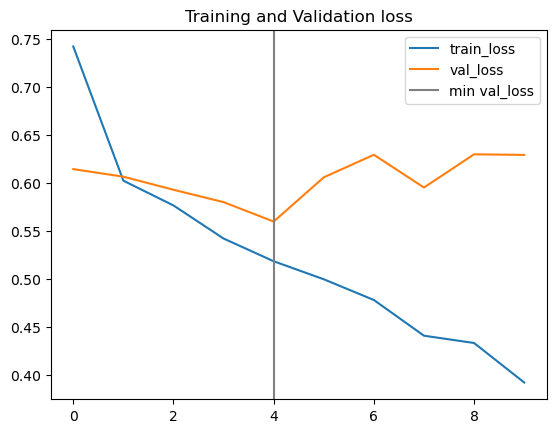

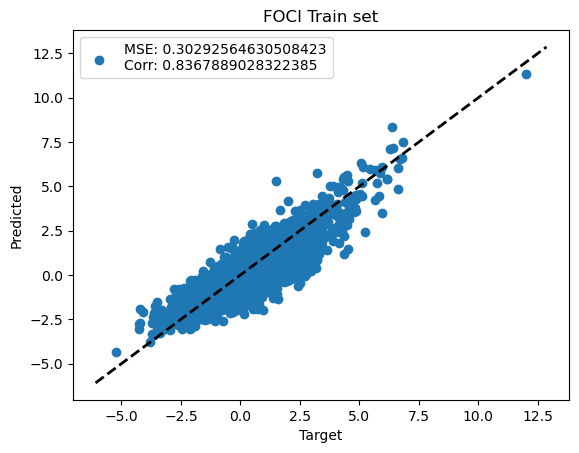

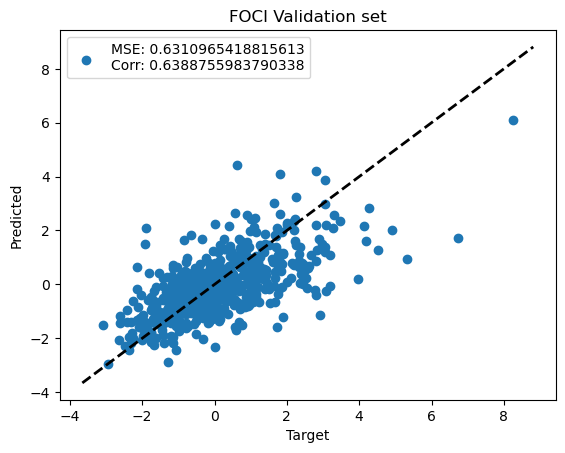

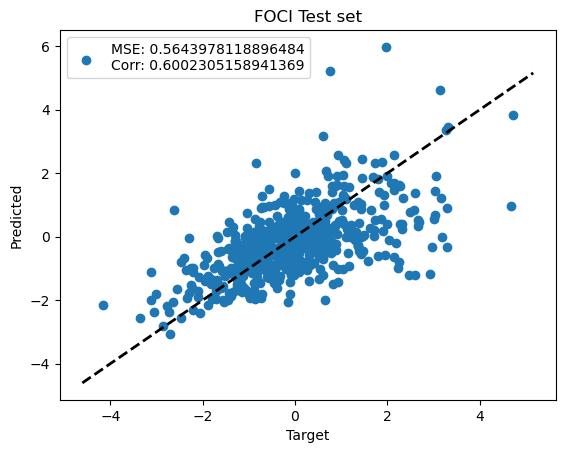

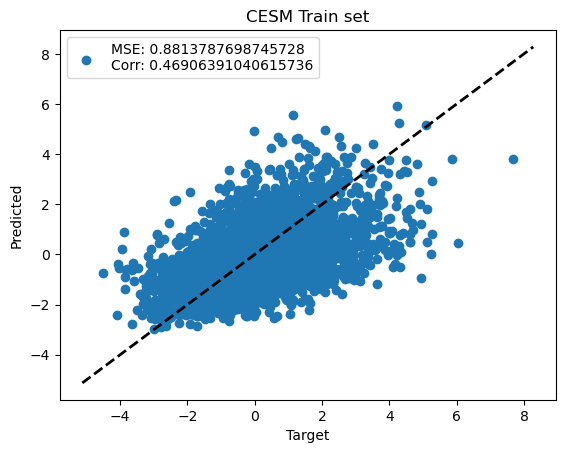

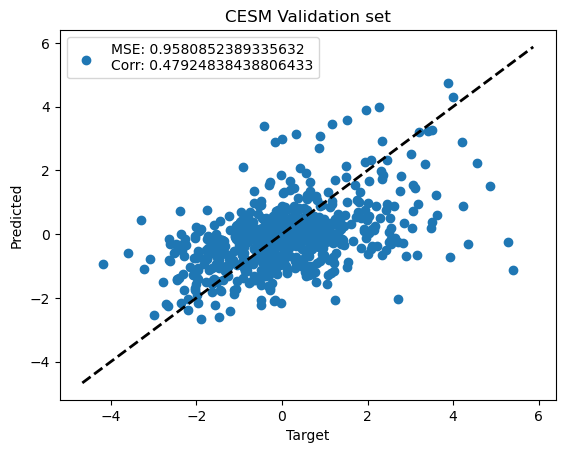

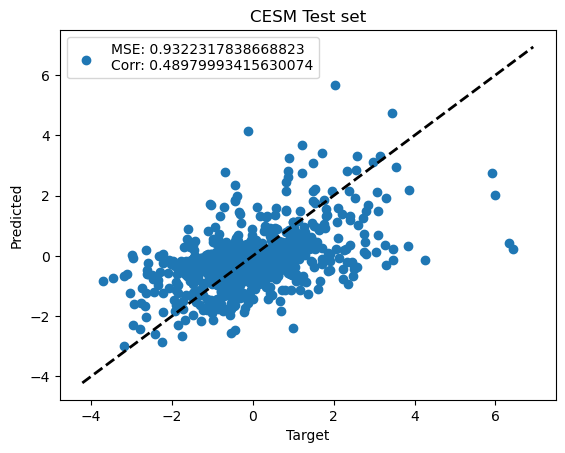

In [45]:
print(encoded_lt0)
evaluate_configuration(encoded_lt0)

{'lead_time': 1, 'seq_length': 48, 'activation_func': <class 'torch.nn.modules.activation.ReLU'>, 'weight_decay': 1e-05, 'learning_rate': 0.0025, 'lstm_neurons': 64, 'lstm_layers': 2, 'fc_neurons': 8, 'fc_layers': 2, 'feature_selection': ['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'AMO', 'ENSO_3', 'ENSO_34', 'ENSO_4', 'PREC_SAHEL', 'SAT_N_LAND'], 'month_encoding': 'normal', 'encoding': 'one_hot_scaled'}


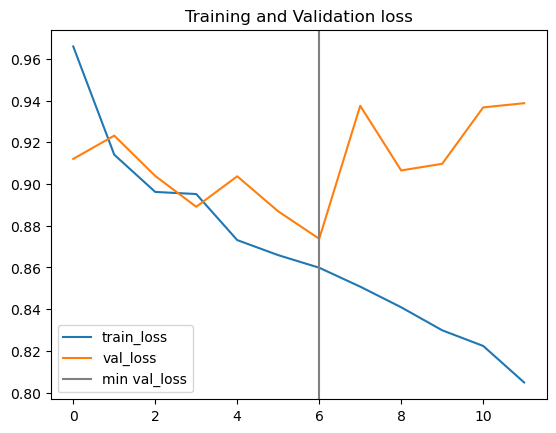

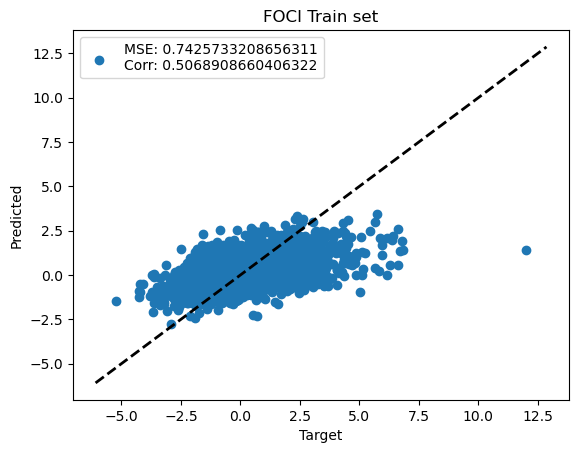

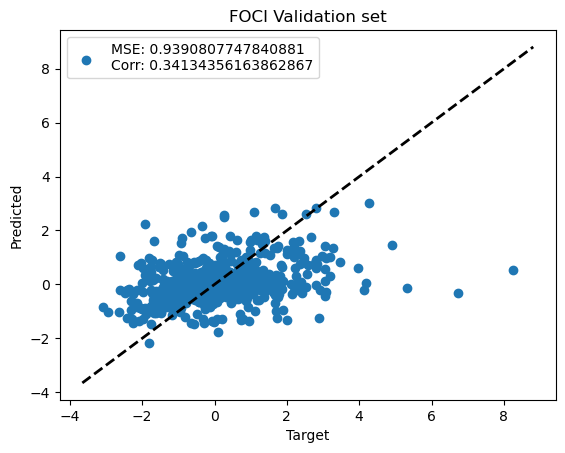

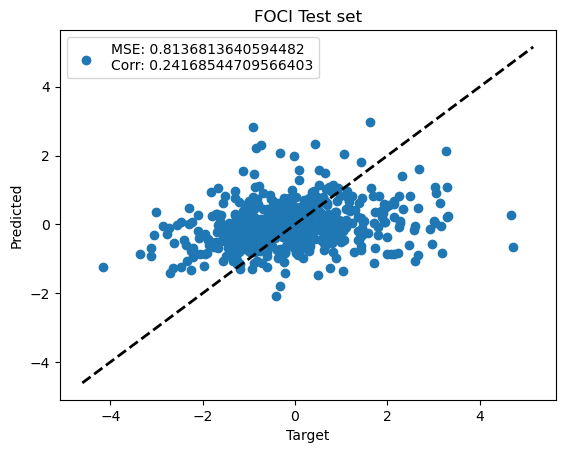

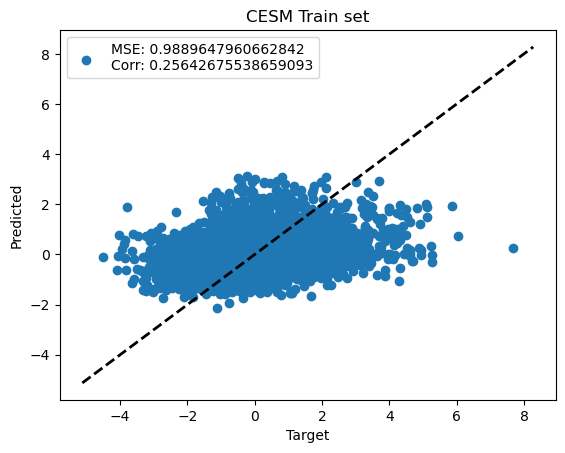

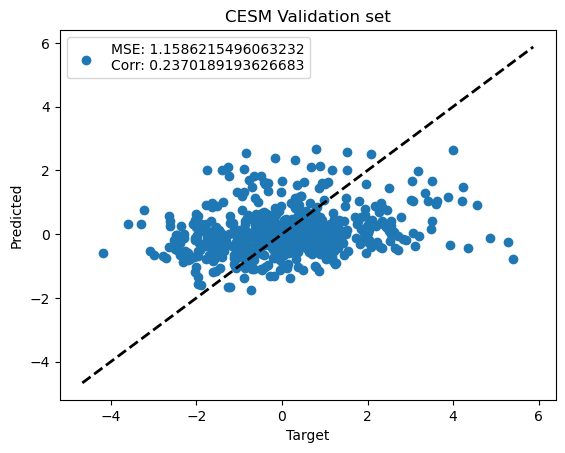

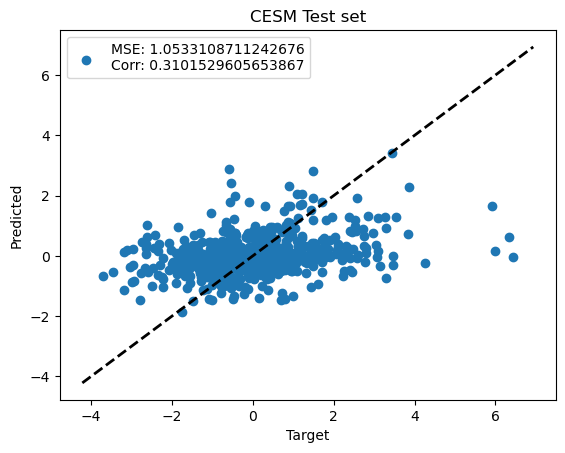

In [46]:
print(encoded_lt1)
evaluate_configuration(encoded_lt1)

{'lead_time': 3, 'seq_length': 22, 'activation_func': <class 'torch.nn.modules.activation.ReLU'>, 'weight_decay': 1e-05, 'learning_rate': 0.0025, 'lstm_neurons': 64, 'lstm_layers': 2, 'fc_neurons': 8, 'fc_layers': 2, 'feature_selection': ['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'AMO', 'ENSO_12', 'ENSO_3', 'ENSO_34', 'ENSO_4'], 'month_encoding': 'normal', 'encoding': 'one_hot_scaled'}


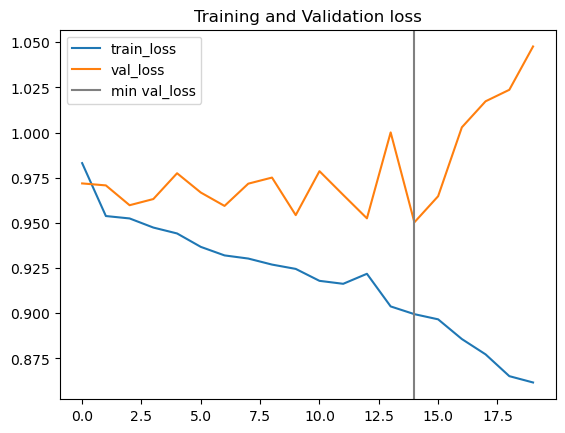

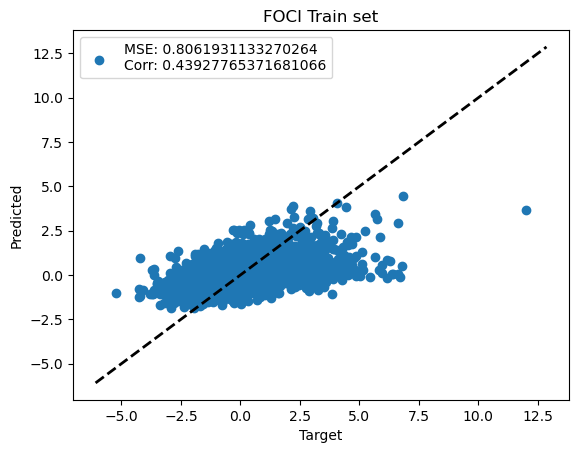

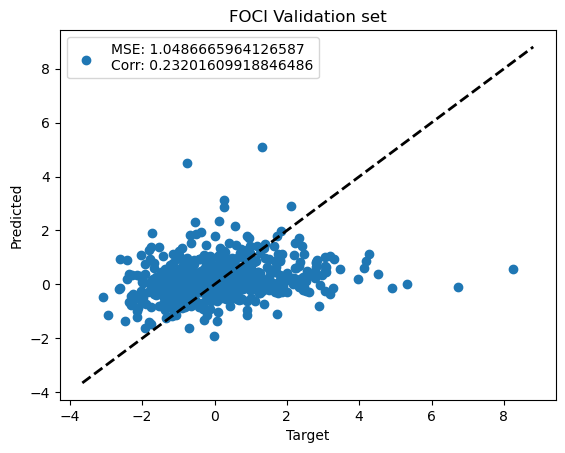

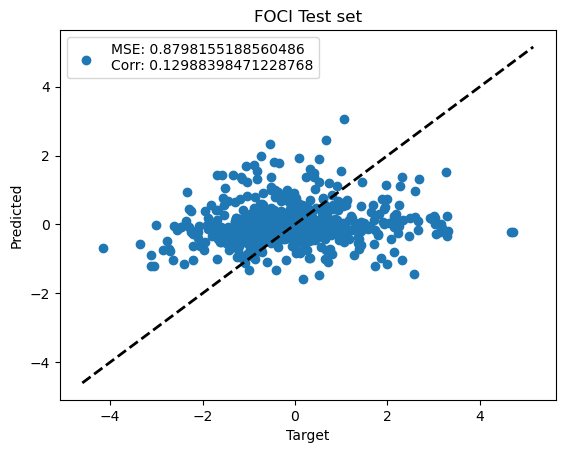

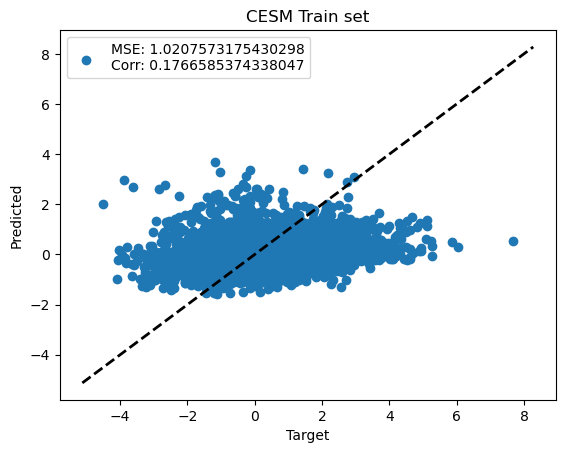

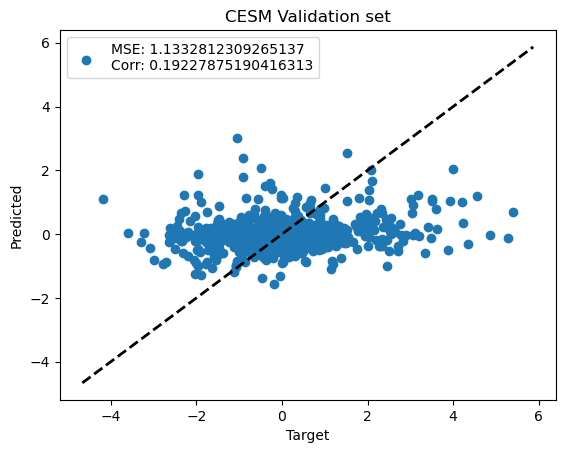

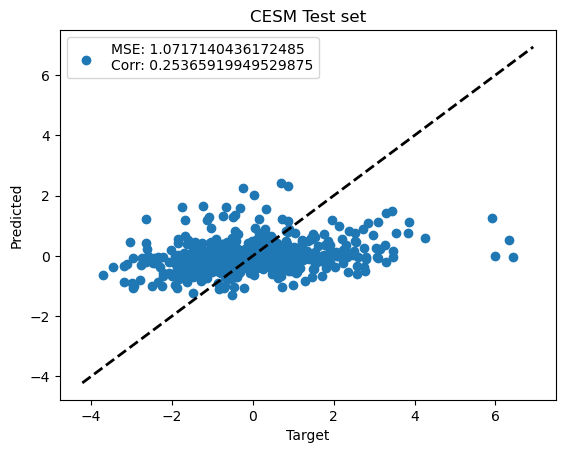

In [47]:
print(encoded_lt3)
evaluate_configuration(encoded_lt3)

{'lead_time': 6, 'seq_length': 12, 'activation_func': <class 'torch.nn.modules.activation.ReLU'>, 'weight_decay': 1e-05, 'learning_rate': 0.0025, 'lstm_neurons': 64, 'lstm_layers': 2, 'fc_neurons': 8, 'fc_layers': 2, 'feature_selection': ['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'AMO', 'ENSO_12', 'ENSO_3', 'ENSO_34', 'SAM_PC', 'SAT_S_LAND', 'SSS_SA', 'SST_ESIO'], 'month_encoding': 'normal', 'encoding': 'one_hot'}


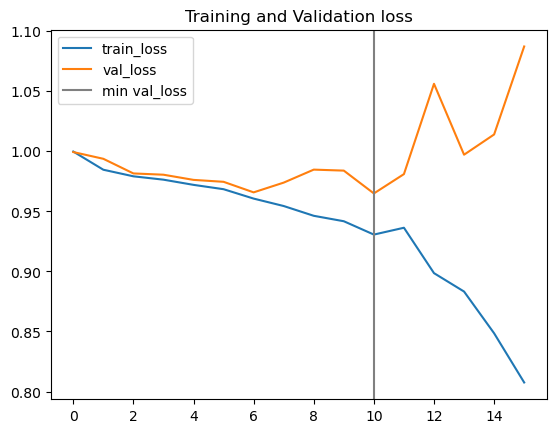

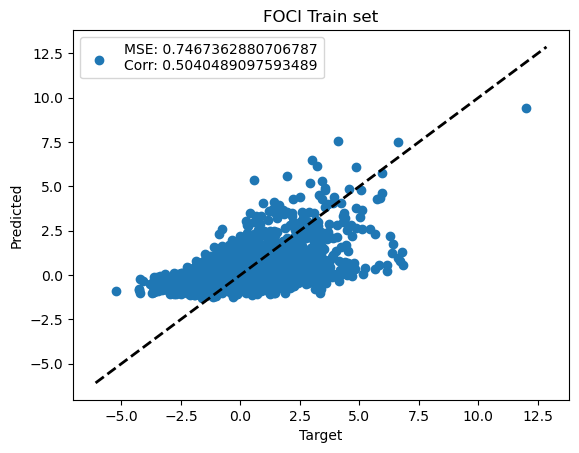

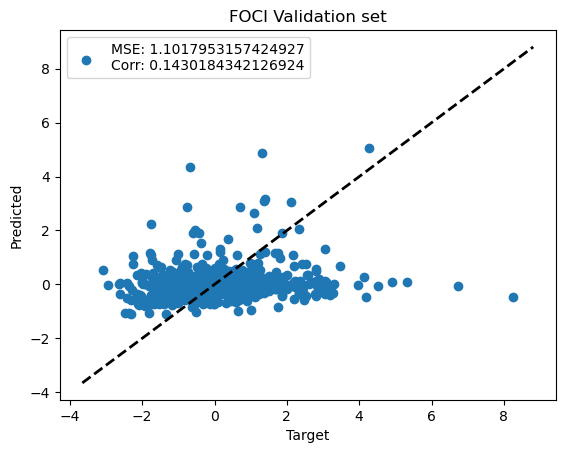

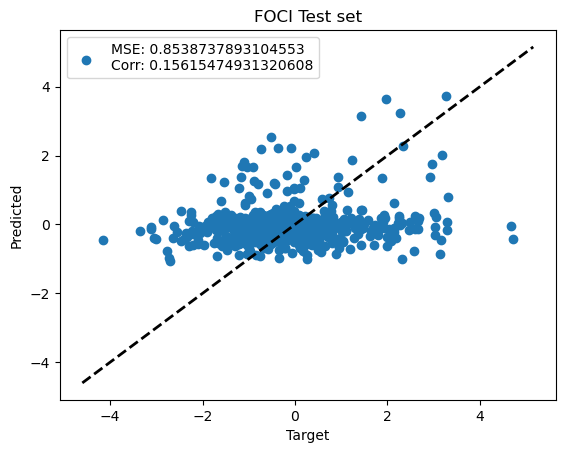

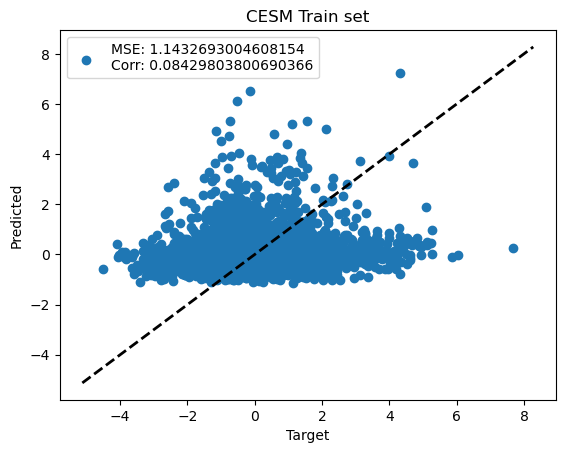

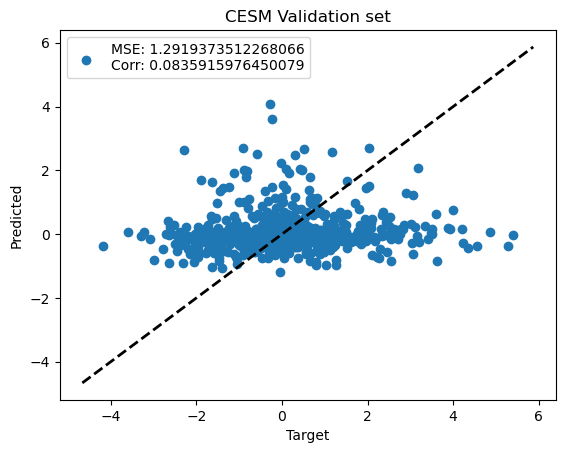

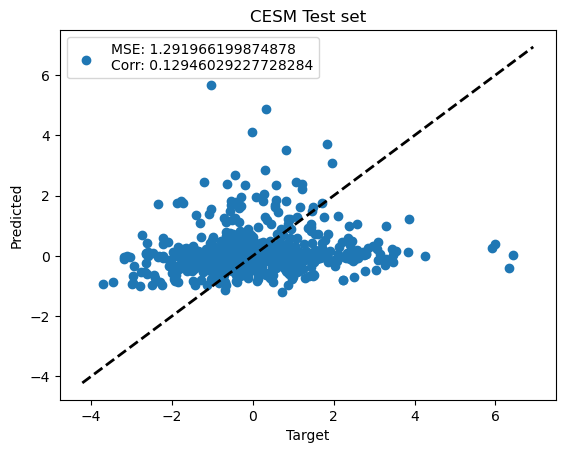

In [48]:
print(encoded_lt6)
evaluate_configuration(encoded_lt6)